#Цели и задачи проекта
## Цель:
Разработать и оценить методы предобработки текста и классификации текстов по топикам, используя различные подходы, такие как модели для векторизации (w2v, FastText) и алгоритмы классификации (Random Forest, SVM).

##Задачи
1. Предобработка текста: Исследовать возможности и провести сравнение двух библиотек для предобработки текста (Natasha и spaCy), включая токенизацию и лемматизацию.

2. Обучение модели для нахождения связанных слов: Использовать алгоритмы Word2Vec (w2v) и FastText для векторизации текста и нахождения контекстно схожих слов.

3. Классификация текстов по топикам: Применить алгоритмы классификации (например, Random Forest и SVM) для классификации текстов и оценки их эффективности.

In [1]:
# Установка совместимых версий
!pip install -U scipy==1.10.1 gensim==4.3.2 scikit-learn pandas==2.2.2 matplotlib tqdm --force-reinstall

  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/l

In [2]:
pip install natasha

ERROR: Operation cancelled by user


In [27]:
import pandas as pd
import re
import time
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger
import gensim.downloader
from gensim.models import Word2Vec, FastText
import spacy
from spacy import load
from spacy.lang.ru.examples import sentences
from spacy.lang.ru import Russian
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
nltk.download('punkt_tab')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Раздел 1: Загрузка данных и анализ

In [ ]:
data = pd.read_csv('/content/articles.csv')

In [ ]:
print(f'Размер датасета: {data.shape}')
data.head()

Размер датасета: (4595, 10)


,id,url,title,subtitle,summary,content,datetime,topic,year,content_clean
0,1455725,https://russian.rt.com/world/article/1455725-e...,Существенные разногласия: как в ЕС намерены от...,Премьер Италии призвала ЕС не реагировать инст...,Премьер-министр Италии Джорджа Мелони призвала...,Руководство Европейского союза должно сохранят...,2025-03-29 00:00:00,world,2025,руководство европейский союз должный сохранять...
1,1455731,https://russian.rt.com/world/article/1455731-s...,«Закабаление целой страны»: что известно о нов...,Договор с США о полезных ископаемых может поме...,Новый вариант договора о полезных ископаемых п...,Новый проект соглашения о полезных ископаемых ...,2025-03-28 20:41:00,world,2025,новый проект соглашение полезный ископаемое ва...
2,1455757,https://russian.rt.com/world/article/1455757-o...,«Это было очень страшно»: очевидцы — о землетр...,Очевидцы рассказали о землетрясении в Мьянме и...,"В Бангкоке, где сейчас, по данным АТОР, находя...","В Таиланде произошло мощное землетрясение, в Б...",2025-03-28 17:41:00,world,2025,таиланд произойти мощный землетрясение бангкок...
3,1455152,https://russian.rt.com/world/article/1455152-e...,Идеология против прагматизма: как ЕС препятств...,ЕС сохранит санкции до полного вывода российск...,Евросоюз не намерен снимать санкции с РФ до те...,Евросоюз может смягчить или снять антироссийск...,2025-03-28 00:32:00,world,2025,евросоюз мочь смягчить снять антироссийский са...
4,1455303,https://russian.rt.com/world/article/1455303-r...,Погибли шесть россиян: что известно об аварии ...,Шесть россиян погибли при аварии туристическог...,В результате аварии прогулочного батискафа в Х...,Шесть россиян погибли в результате аварии прог...,2025-03-27 23:03:00,world,2025,шесть россиянин погибнуть результат авария про...


Удалим данные, где нет контента и посмотрим на сбалансированность по топикам

In [15]:
data = data.dropna(subset = ['content'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4595 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4595 non-null   int64 
 1   url       4595 non-null   object
 2   title     4595 non-null   object
 3   subtitle  4095 non-null   object
 4   summary   4595 non-null   object
 5   content   4595 non-null   object
 6   datetime  4595 non-null   object
 7   topic     4595 non-null   object
dtypes: int64(1), object(7)
memory usage: 323.1+ KB


<Axes: ylabel='topic'>

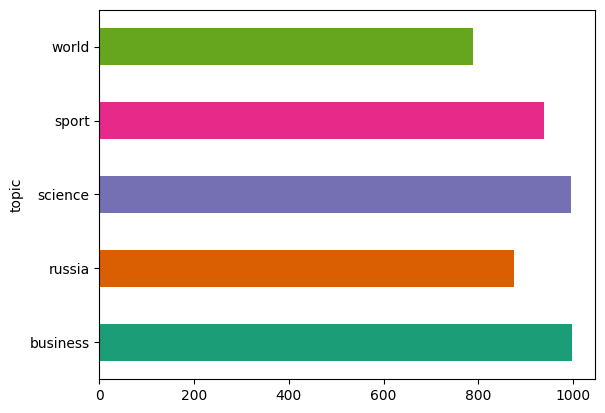

In [ ]:
data.groupby(['topic']).size().plot(kind = 'barh', color=sns.palettes.mpl_palette('Dark2'))

## Вывод по разделу:
Наблюдается дисбаланс по топикам. Для предобработки и анализа данных это не страшно, но это может повлиять в дальнейшем на наш классификатор. На данном этапе попробуем поработать с несблансированным классом, возможно это приведет к неплохим результатам.

# Раздел 2: Предобработка текста

## Цель задачи:
Сравнить библиотеки Natasha и spaCy для предобработки текста, чтобы выбрать наиболее эффективный инструмент для дальнейшего анализа текста на русском языке.

## Задачи:

1. Использовать библиотеку Natasha, которая включает все необходимые элементы предобработки (токенизация, лемматизация), и провести тестирование на примере текстов на русском языке.

2. Сравнить результаты с библиотекой spaCy, которая является стандартной для работы с текстом на разных языках.

Предобработка текста включает в себя:
- lowering
- tokenize
- lemmatize
- remove symbols
- remove stop-words

Будем работать с библоитеками Natasha и spacy для сравнения двух библиотек
Natasha включает в себя все необходимые нам элементы предобработки (лемматизация и токенизация), а также показывает сравнительно неплохой результат при работе с текстом на русском языке.
Библиотека spacy является стандартной библиотекой для работы с текстом

In [ ]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
stop_words = stopwords.words('russian')

In [ ]:
def text_prep_natasha(text) -> str:
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)

  for token in doc.tokens:
    token.lemmatize(morph_vocab)

  lemmas = [_.lemma for _ in doc.tokens]
  words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
  filtered_words = [word for word in words if word not in stop_words]
  return ' '.join(filtered_words)

In [ ]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 41.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
load_model = load('ru_core_news_sm')

In [ ]:
def text_prep_spacy(text)-> str:
  text_cleaned = re.sub(r'[^\w\s]', ' ', text)
  text_cleaned = re.sub(r'\s+', ' ', text_cleaned).lower()
  lemmas = []
  for doc in load_model.pipe([text_cleaned]):
    lemmas.extend([n.lemma_ for n in doc])

  words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
  filtered_words = [word for word in words if word not in stop_words]

  return ' '.join(filtered_words)

Выберем 30 случайных текстов и обработаем их с помощью 2х библиотек

In [ ]:
data_test = data.iloc[:30]

In [ ]:
%%time

natasha_prep = data_test['content'].apply(text_prep_natasha)

CPU times: user 10.1 s, sys: 18.3 ms, total: 10.2 s
Wall time: 8.74 s


In [ ]:
%%time

spacy_prep = data_test['content'].apply(text_prep_spacy)

CPU times: user 10.2 s, sys: 32 ms, total: 10.2 s
Wall time: 10.3 s


Уже видим, что Natasha работает быстрее. Проверим, насколько хорошо справились с задачей обе модели

In [ ]:
spacy_prep[0]

'руководство европейский союз должный сохранять спокойствие условие введение соединёнными штат пошлина европейский товар мнение интервью газета financial times высказать премьер министр италия джорджа мелони складываться впечатление просто реагировать инстинктивно подобный вопрос нужный говорить спокойно давать подумаем сказать мелони говорить власть слово уровень взаимный пошлина штат евросообществом примерно одинаков высокий тариф некоторый товар создавать напряжённость двусторонний отношение иметься существенный разногласие отдельный товар работать найти хороший общий решение считать политик это акцентировать внимание необходимость предотвратить раскол евро атлантический партнёр подчеркнуть тарифный политика трамп необходимый дать конфронтационный ответ италия мочь хороший отношение соединёнными штат италия мочь сделать помочь избежать конфронтация сша европа навести мост это сделать это интерес европеец подчеркнуть мелони также тема перспектива торговый война европа оценить план тр

In [ ]:
natasha_prep[0]

'руководство европейский союз должный сохранять спокойствие условие введение соединить штат пошлина европейский товар мнение интервью газета financial times высказать италия джордж мелонь складываться впечатление просто реагировать инстинктивно подобный вопрос нужный говорить спокойно давать подумать сказать мелонь говорить власть слово уровень взаимный пошлина штат евросообщество примерно одинаковый высокий тариф некоторый товар создавать напряженность двусторонний отношение иметься существенный разногласие отдельный товар работать найти хороший общий решение считать политик это акцентировать внимание необходимость предотвратить раскол партнер подчеркнуть тарифный политика трамп необходимый дать конфронтационный ответ италия мочь хороший отношение соединить штат италия мочь сделать помочь избежать конфронтация сша европа навести мост это сделать это интерес европеец подчеркнуть мелонь также тема перспектива торговый война европа оценить план трамп ввести пошлина товар польша дональд т

## Вывод по разделу
Обе библиотеки продемонстрировали хорошие результаты в предобработке текста. Все слова были приведены к начальной форме (инфинитиву), и стоп-слова были удалены.
Однако Natasha показала немного лучшую производительность по времени, поэтому для дальнейшего анализа мы будем использовать эту модель.

In [ ]:
tqdm.pandas()

In [ ]:
%%time
data['content_clean']= data['content'].progress_apply(text_prep_natasha)

  0%|          | 0/4595 [00:00<?, ?it/s]

CPU times: user 28min 49s, sys: 4.04 s, total: 28min 53s
Wall time: 17min 25s


# Раздел 3: Обучение модели находить связанные слова (w2v и FastText)

## Цель задачи:
Провести векторизацию текста с помощью моделей Word2Vec (w2v) и FastText для нахождения контекстно схожих слов.

In [ ]:
%%time
model = Word2Vec(sentences = data['content_clean'].str.split(),
                 vector_size=300,
                 min_count=10,
                 window=3)

CPU times: user 1min 3s, sys: 293 ms, total: 1min 4s
Wall time: 39.5 s


In [ ]:
# Сохраняем модель
#model.save("word2vec_model.model")

In [ ]:
model.wv.most_similar(positive=["страна"])

[('государство', 0.6554433703422546),
 ('континент', 0.5207175016403198),
 ('союзник', 0.5080090165138245),
 ('республика', 0.5072531700134277),
 ('европа', 0.49879321455955505),
 ('китай', 0.4641983211040497),
 ('германия', 0.4618470072746277),
 ('евросоюз', 0.46160030364990234),
 ('россия', 0.4601280093193054),
 ('блок', 0.45577409863471985)]

In [ ]:
%%time
model_ft = FastText(sentences = data['content_clean'].str.split(),
                 vector_size=300,
                 min_count=10,
                 window=3)

CPU times: user 6min 41s, sys: 3.29 s, total: 6min 44s
Wall time: 4min 4s


In [ ]:
model_ft.wv.most_similar(positive=["страна"], topn=10)

[('страж', 0.8192353844642639),
 ('странно', 0.8142385482788086),
 ('рана', 0.7823273539543152),
 ('страница', 0.7693691253662109),
 ('стража', 0.7689668536186218),
 ('страх', 0.7232844829559326),
 ('мембрана', 0.7099505066871643),
 ('струна', 0.7004162669181824),
 ('охрана', 0.6881052255630493),
 ('гана', 0.6497061848640442)]

## Выводы по разделу:
* FastText работает с n-граммами, что приводит к выделению схожих частей слов (например, "страна" и "страж"). Это может быть полезно в некоторых задачах, но для данной задачи такие результаты не подходят.

* w2v выявляет более контекстно схожие слова (например, "страна" и "государство"), что лучше соответствует задаче.

In [ ]:
#data.to_csv('clean_articles.csv', index = None)

# Раздел 4: Проецирование результатов работы w2v на графике

In [ ]:
def vizualization_pca(model,size = 100, title="PCA проекция слов"):
  word_vectors = model.wv[model.wv.index_to_key]
  pca = PCA(n_components = 2)
  word_vectors_pca = pca.fit_transform(word_vectors[:size])

  plt.figure(figsize=(15, 15))
  plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1])
  words = list(model.wv.index_to_key)
  for i, word in enumerate(words[:size]):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i,1]), fontsize=9)
  plt.title(title)
  plt.xlabel('Component PCA 1')
  plt.ylabel('Component PCA 2')
  plt.grid(True)
  plt.show()


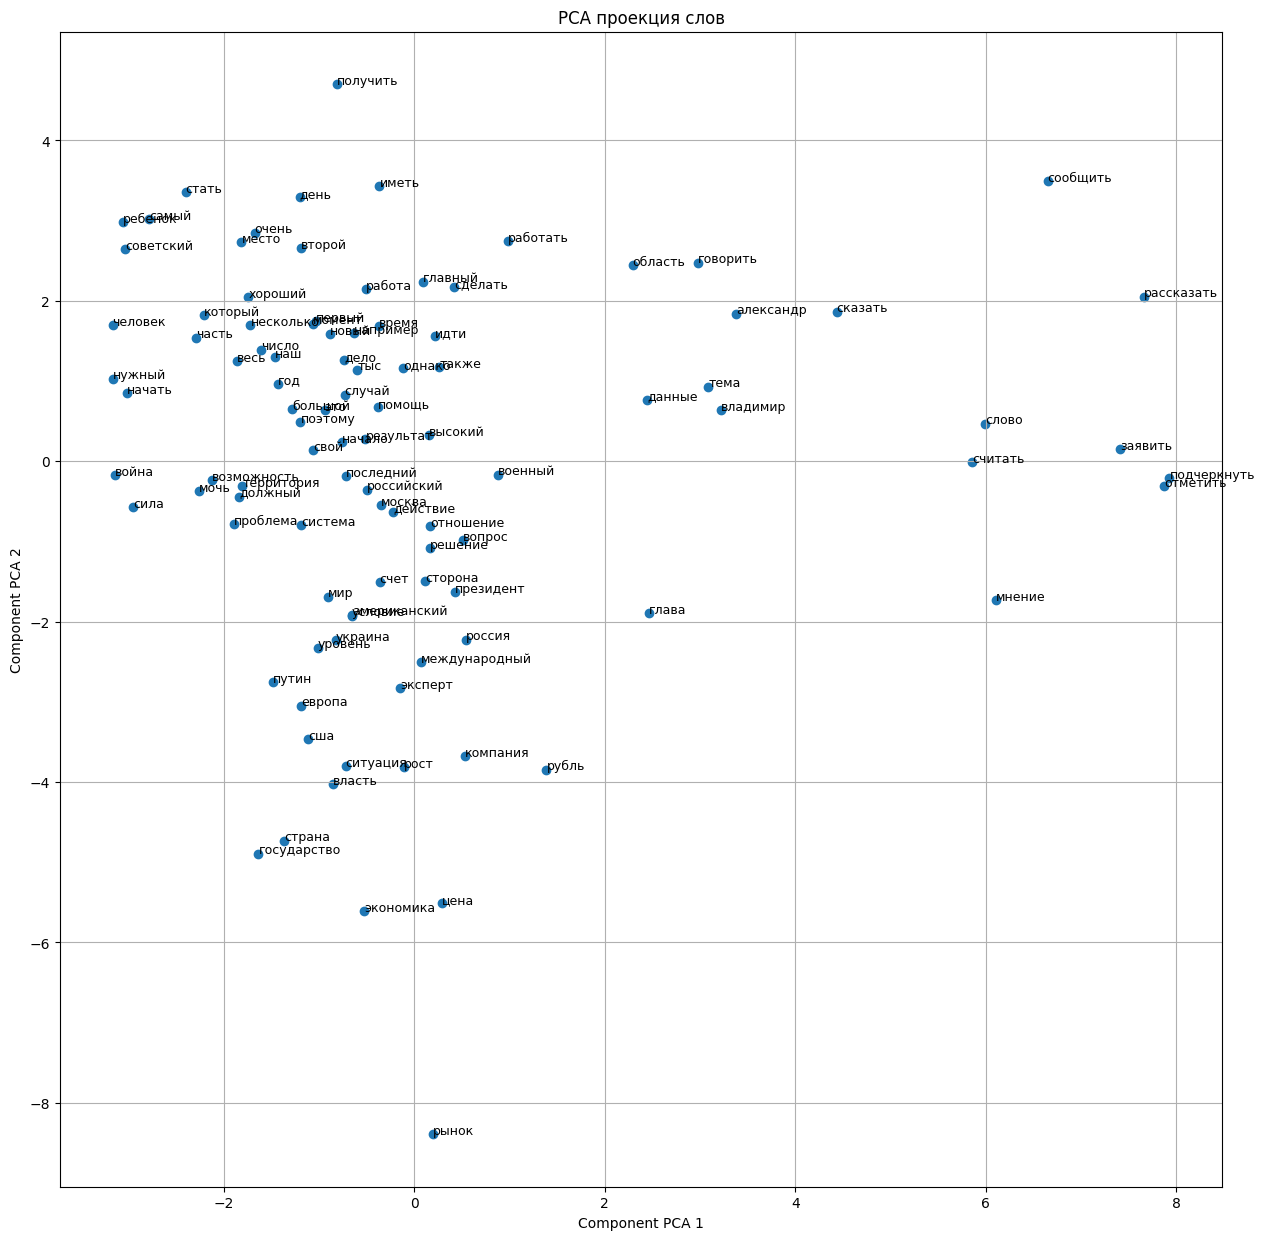

In [ ]:
vizualization_pca(model,size=100)

## Выводы по работе модели:
На графике видно, что слова вроде "глава", "президент" и "россия" находятся близко друг к другу, что подтверждает корректность работы модели. Также видно, что "страна" и "государство", "европа" и "сша" также находятся в одной области, что свидетельствует о хорошем качестве векторизации и правильности кластеризации.

# Раздел 5: Кластеризация полученных данных w2v

## Цель задачи:
Попробовать кластеризовать векторы слов, полученные с помощью w2v, для выделения различных тем (топиков).

In [ ]:
def cluster_words_kmeans(model, size=100, n_clusters=5):
  words = model.wv.index_to_key[:size]
  word_vectors = np.array([model.wv[word] for word in words])
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  kmeans.fit(word_vectors)

  pca = PCA(n_components=2)
  word_vectors_pca = pca.fit_transform(word_vectors)

  labels = kmeans.labels_

  plt.figure(figsize=(8, 8))
  scatter = plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], c=labels, cmap='tab10', linewidth=4)

  for i, word in enumerate(words[::10]):
        plt.annotate(word, (word_vectors_pca[i, 0] + 0.1, word_vectors_pca[i, 1] + 0.1), fontsize=5)

  plt.title("Кластеризация слов (KMeans)")
  plt.xlabel("PCA Component 1")
  plt.ylabel("PCA Component 2")
  plt.legend(handles=scatter.legend_elements()[0], labels=range(n_clusters))
  plt.grid(True)
  plt.show()

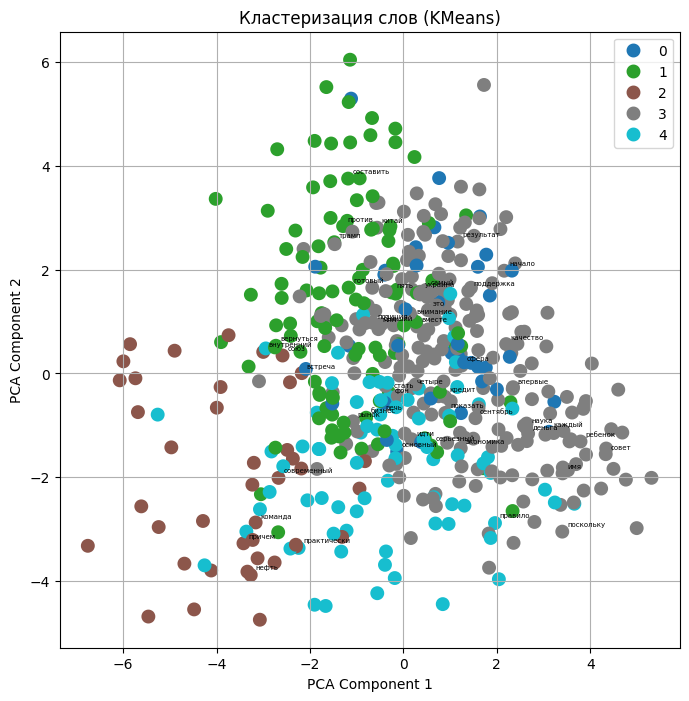

In [ ]:
cluster_words_kmeans(model, size=500)

## Результаты:
Кластеризация показывает, что слова группируются по темам. Особенно сильно выделяются кластеры 1 и 2, что свидетельствует о наличии различных тематических групп, где слова внутри кластера сильно пересекаются, а между кластерами – мало общих слов.

# Раздел 6: Валидация модели и классификация текстов по топикам

## Цель задачи:
Провести валидацию модели классификации текстов по топикам, используя различные методы векторизации (усреднение векторов слов, tf-idf) и классификаторы (Random Forest, SVM).

## Задачи:

Получить вектор для предложения двумя способами: усреднить вектора слов или взвесить их по tf-idf.

Создать класс для генерации вектора предложения, принимая модель и слова предложения как входные параметры.

Добавить параметр class_weight в классификаторы, чтобы учесть несбалансированность классов

In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data.content.str.split(), data.topic.values)

model = Word2Vec(sentences=Xtrain,
                 vector_size = 300,
                 min_count = 10,
                 window = 3)

Создадим класс, который будет возвращать вектор всего предложения. В качестве входных параметров: модель, слова предложения.

In [6]:
class MeanEmbeddingVectorizer:
  def __init__(self, model):
    self.word2vec = model.wv
    self.dim = model.vector_size

  def fit(self, X, y):
    return self

  def transform(self, X):
    return np.array([
        np.mean([self.word2vec.get_vector(w)
        for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis = 0)
        for words in X])

В классификаторах добавим параметр class_weight чтобы модель учитывала несбалансированность классов при обучении

In [17]:
import joblib

pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)), ('clf', RandomForestClassifier(class_weight='balanced'))])
pipe.fit(Xtrain, ytrain)
joblib.dump(pipe, 'classificator.pkl')

print(classification_report(ytest, pipe.predict(Xtest)))

              precision    recall  f1-score   support

    business       0.97      1.00      0.98       264
      russia       0.83      0.81      0.82       210
     science       0.92      0.94      0.93       227
       sport       0.99      0.98      0.98       246
       world       0.92      0.90      0.91       202

    accuracy                           0.93      1149
   macro avg       0.93      0.92      0.93      1149
weighted avg       0.93      0.93      0.93      1149



Мы уже получили довольно неплохие результаты на тесте. Попробуем улучшить полученные данные.
Для начала изменим метод получения вектора предложения с помощью tf-idf весов
Стоит отметить, что в классах, где наблюдался дисбаланс(world, russia) точность предсказания самая низкая.

In [9]:
class TFIDFEmbeddingVectorizer:

  def __init__(self, model):
    self.w2v = model.wv
    self.dim = model.vector_size
    self.weights =  None

  def fit(self, X, y):
    tfidf = TfidfVectorizer(analyzer=lambda x: x)
    tfidf.fit(X)
    max_idf = max(tfidf.idf_)
    self.weights = defaultdict(
        lambda: max_idf,
        [(w, tfidf.idf_[i]) for w,i in tfidf.vocabulary_.items()]
    )
    return self

  def transform(self, X):
    return np.array([
        np.mean([self.w2v.get_vector(w)*self.weights[w]
                 for w in words if w in self.w2v] or [np.zeros(self.dim)], axis = 0)
        for words in X
    ])

In [18]:
pipe2 = Pipeline([
    ('w2v', TFIDFEmbeddingVectorizer(model)),
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])

pipe2.fit(Xtrain, ytrain)

print(classification_report(ytest, pipe2.predict(Xtest)))

              precision    recall  f1-score   support

    business       0.97      1.00      0.99       264
      russia       0.86      0.86      0.86       210
     science       0.94      0.96      0.95       227
       sport       0.99      0.99      0.99       246
       world       0.95      0.89      0.92       202

    accuracy                           0.95      1149
   macro avg       0.94      0.94      0.94      1149
weighted avg       0.95      0.95      0.94      1149



Результат стал немного лучше. Попробуем также вместо RF воспользоваться другой модели для классификации например SVM

In [19]:
pipe3 = Pipeline([
    ('w2v', TFIDFEmbeddingVectorizer(model)),
    ('svm_classifier', SVC(kernel='rbf', degree=4, C=1.0, class_weight='balanced'))
])

pipe3.fit(Xtrain, ytrain)
print(classification_report(ytest, pipe3.predict(Xtest)))

              precision    recall  f1-score   support

    business       0.96      1.00      0.98       264
      russia       0.85      0.82      0.83       210
     science       0.92      0.95      0.94       227
       sport       1.00      0.99      0.99       246
       world       0.94      0.89      0.91       202

    accuracy                           0.94      1149
   macro avg       0.93      0.93      0.93      1149
weighted avg       0.94      0.94      0.93      1149



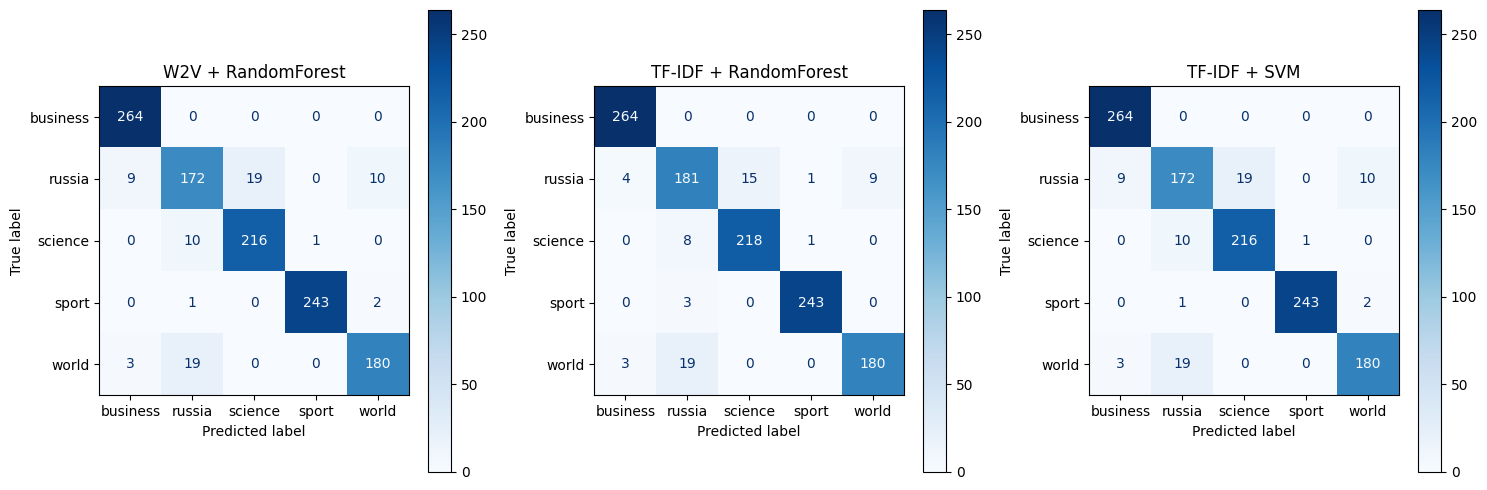

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

titles = ['W2V + RandomForest', 'TF-IDF + RandomForest', 'TF-IDF + SVM']
pipes = [pipe, pipe2, pipe3]

for i, (pipe, title) in enumerate(zip(pipes, titles)):
  ConfusionMatrixDisplay.from_estimator(pipe, Xtest, ytest, ax = ax[i], cmap = 'Blues')
  ax[i].set_title(title)
  ax[i].grid(False)

plt.tight_layout()
plt.show()

In [37]:
pip install dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.4 MB/s eta 0:00:00


In [38]:
#сохранение наилучшей модели
import dill

# Сохранение модели
with open('news_classificator.pkl', 'wb') as f:
    dill.dump(pipe2, f)

# Общий итог:
В целом модель показывает отличные результаты, особенно в случае топиков business и sport, где ошибки минимальны.

Есть небольшие пересечения между топиками, но они незначительные и не влияют сильно на общую точность классификации. Например, russia путается с science и world, но эти пересечения не столь выражены.

**sport** и **business** выделяются как самые хорошо различаемые категории.

**world** и **russia** показывают некоторые ошибки, что может быть связано с пересечениями в контенте (например, новости о международной политике или спортивных событиях в России).